In [3]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso, Ridge, LassoCV
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor ,VotingRegressor, BaggingRegressor
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
import pickle

In [3]:
housing = pd.read_csv("./train.csv")
housing.head().T

,0,1,2,3,4
Id,1,2,3,4,5
MSSubClass,60,20,60,70,60
MSZoning,RL,RL,RL,RL,RL
LotFrontage,65,80,68,60,84
LotArea,8450,9600,11250,9550,14260
...,...,...,...,...,...
MoSold,2,5,9,2,12
YrSold,2008,2007,2008,2006,2008
SaleType,WD,WD,WD,WD,WD
SaleCondition,Normal,Normal,Normal,Abnorml,Normal


In [4]:
#Variables con valores nulos
housing.columns[housing.isna().sum() > 0]

Index(['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence',
       'MiscFeature'],
      dtype='object')

Se eliminarán todas las variables que tengan más del 10% de valores nulos.

In [5]:
porcentaje_nulos = housing[housing.columns[housing.isna().sum() > 0]].isna().sum()/housing.shape[0]
eliminar_variables = porcentaje_nulos[porcentaje_nulos>=.1]
eliminar_variables

LotFrontage    0.177397
Alley          0.937671
FireplaceQu    0.472603
PoolQC         0.995205
Fence          0.807534
MiscFeature    0.963014
dtype: float64

In [6]:
housing.drop(columns = eliminar_variables.index.values,inplace=True)
housing.drop(columns = "Id", inplace = True)

In [7]:
#Vemos cuales son las variables con valores nulos restantes
(housing.columns)[housing[housing.GarageCond.notna()].isna().sum()>0]

Index(['MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinType2', 'Electrical'],
      dtype='object')

In [8]:
#Total de observaciones de la base
n_original = housing.shape[0]

In [9]:
#Se decidió no imputar valores (por posible riesgo de sesgo), ya que al quitar
#todas las observaciones con valores nulos, se pierde menos del 10% de la base
#original.

#Una alternativa de modelado, sería imputar los valores de una manera cuidadosa
#(intentando entender el por qué faltan valores)
housing  = housing[housing.GarageCond.notna()]
housing = housing[housing.BsmtExposure.notna()]
housing  = housing[housing.MasVnrType.notna()]
housing  = housing[housing.BsmtFinType2.notna()]
housing  = housing[housing.Electrical.notna()]
housing.shape[0]/n_original

0.9164383561643835

In [10]:
#Guardamos todas las variables numéricas
variables_num = housing.drop(columns="SalePrice").columns[housing.drop(columns="SalePrice").dtypes != "object"]
variables_num

Index(['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

In [11]:
#Hacemos lo propio con las categóricas
variables_cat = housing.columns[housing.dtypes == "object"]
variables_cat

Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
       'PavedDrive', 'SaleType', 'SaleCondition'],
      dtype='object')

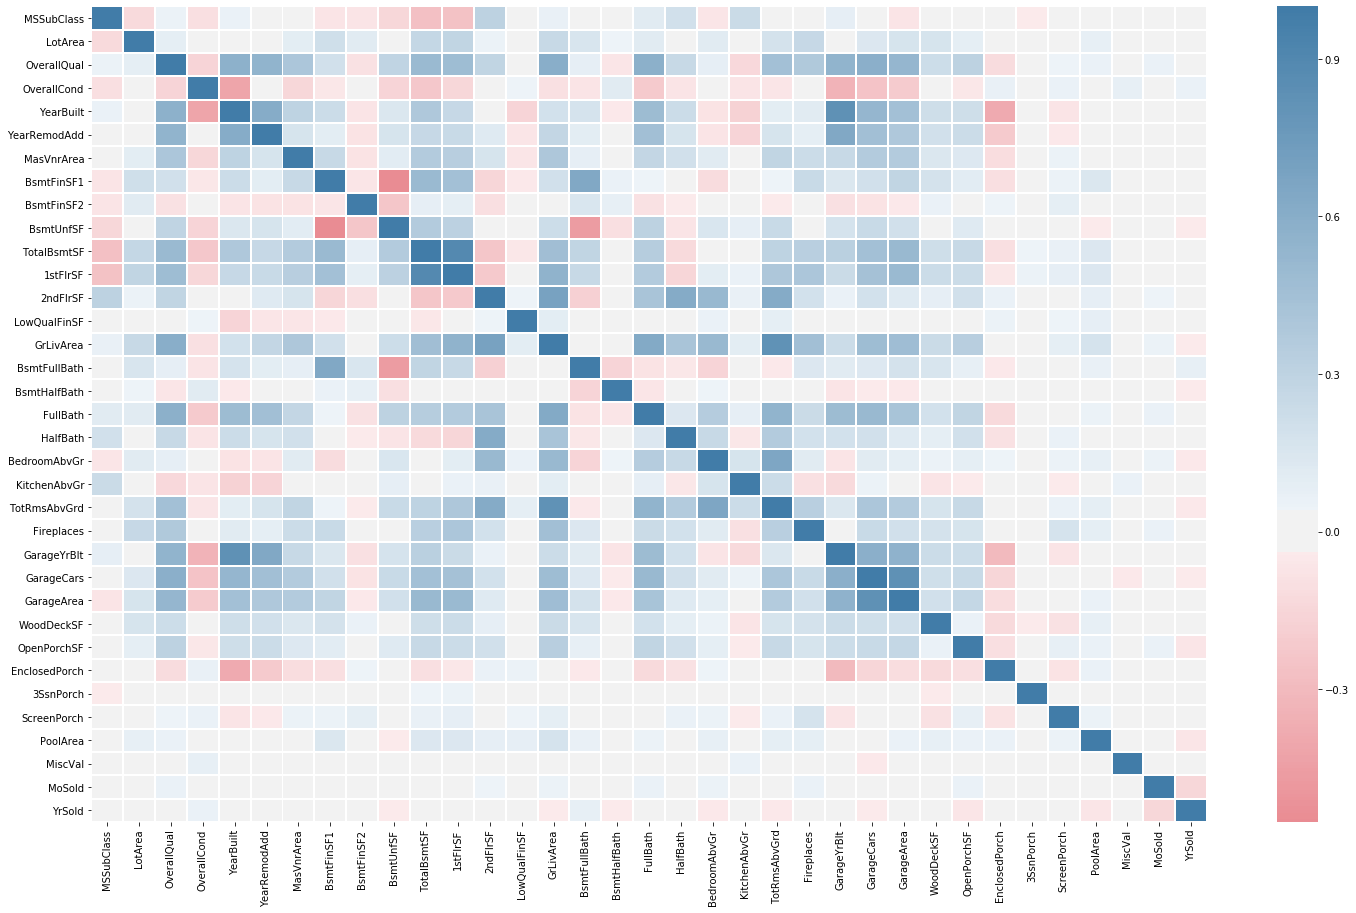

In [12]:
plt.figure(figsize=(25,15))
cmap = sns.diverging_palette(h_neg=10,
                            h_pos = 240,
                            as_cmap=True)
sns.heatmap(housing[variables_num].corr(), center = 0,
           cmap = cmap, linewidths=1, annot = False, fmt = ".2f")

In [13]:
scaler = StandardScaler()
df_std = pd.DataFrame(scaler.fit_transform(housing[variables_num]),
                     columns=housing[variables_num].columns)
df_std.head()

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,0.093701,-0.218363,0.589337,-0.553402,1.014157,0.854216,0.461582,0.527157,-0.296255,-0.983421,...,0.249341,-0.779554,0.202294,-0.349612,-0.118688,-0.283203,-0.071771,-0.084535,-1.605319,0.146084
1,-0.876298,-0.107067,-0.165963,2.230251,0.100528,-0.476562,-0.594820,1.120240,-0.296255,-0.678727,...,-0.222023,1.557895,-0.731311,-0.349612,-0.118688,-0.283203,-0.071771,-0.084535,-0.493561,-0.605686
2,0.093701,0.052620,0.589337,-0.553402,0.946480,0.804928,0.278328,0.047458,-0.296255,-0.337652,...,0.570726,-0.779554,-0.088501,-0.349612,-0.118688,-0.283203,-0.071771,-0.084535,0.988784,0.146084
3,0.336201,-0.111906,0.589337,-0.553402,-1.963596,-0.772291,-0.594820,-0.541263,-0.296255,-0.096626,...,0.752844,-0.779554,-0.195636,4.122511,-0.118688,-0.283203,-0.071771,-0.084535,-1.605319,-1.357457
4,0.093701,0.343926,1.344638,-0.553402,0.912642,0.706352,1.291612,0.415954,-0.296255,-0.210318,...,1.791989,0.726453,0.554309,-0.349612,-0.118688,-0.283203,-0.071771,-0.084535,2.100542,0.146084


In [14]:
## Calculamos todas las componentes principales del modelo, esto con la 
## finalidad de quitar las correlaciones lineales entre las variables

In [15]:
pca = PCA()
pca_df = pd.DataFrame(pca.fit_transform(df_std))
print(pca.explained_variance_ratio_.cumsum())

[0.1993644  0.29152397 0.3649239  0.42385415 0.46435805 0.49823285
 0.53148404 0.56359753 0.59485093 0.6253014  0.65502063 0.68377288
 0.71147747 0.73861123 0.76503643 0.7909284  0.81477508 0.83712051
 0.85910893 0.88005311 0.89883812 0.91639109 0.93168345 0.94393595
 0.95496767 0.96424802 0.97223793 0.97897776 0.98522704 0.9900295
 0.99392026 0.99722201 1.         1.         1.        ]


In [16]:
pca_df.columns = [f"PC_{i+1}" for i in range(pca_df.shape[1])]
pca_df.head()

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,...,PC_26,PC_27,PC_28,PC_29,PC_30,PC_31,PC_32,PC_33,PC_34,PC_35
0,1.384645,0.462851,-1.406892,-2.199623,0.621474,-1.160401,0.501163,-0.199081,0.074760,0.005071,...,-0.725915,-0.108428,0.077301,0.217119,-0.344874,-0.192083,-0.114906,-0.151047,2.733659e-14,2.661624e-15
1,-0.451928,-0.909259,1.185096,0.139168,-1.854718,0.412218,-3.384122,0.132334,0.338899,0.668450,...,0.642558,-0.869965,0.915566,0.239288,-0.230919,0.332925,-0.052100,-0.181033,2.149037e-16,1.926842e-16
2,1.520565,0.382892,-1.244287,-1.609073,0.086383,0.453161,0.281041,-0.063671,0.120210,-0.530879,...,-0.412842,0.110313,0.678212,0.288103,0.699458,-0.332117,0.055758,0.043159,-3.948858e-15,-9.233767e-16
3,-0.432584,1.122079,0.817990,0.114317,1.482649,-0.973224,1.499589,1.721926,1.084006,-1.410302,...,-0.915255,-0.365573,-0.831899,0.553974,0.060557,0.407771,1.432616,-0.426924,6.175779e-17,2.721425e-17
4,4.308443,1.268680,-0.214027,-1.459262,0.294188,0.722659,-0.582702,0.132037,-0.052863,-0.936708,...,-0.498996,-0.134952,-0.088849,-0.177375,0.067372,-0.018650,-0.204443,-0.134388,-1.297053e-15,6.148240e-16


In [17]:
#Variables categóricas, las cuales vamos a codificar
housing[variables_cat].head()

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,Electrical,KitchenQual,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
0,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
1,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,...,SBrkr,TA,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
2,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
3,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,...,SBrkr,Gd,Typ,Detchd,Unf,TA,TA,Y,WD,Abnorml
4,RL,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,...,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal


In [18]:
ohe = OneHotEncoder(sparse=False)

In [19]:
ohe_df = pd.DataFrame(ohe.fit_transform(housing[variables_cat]),
                      columns=ohe.get_feature_names(variables_cat))
ohe_df.head()

,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [21]:
#Juntamos las componentes principales y las variables codificadas
df_c = pd.concat([pca_df.reset_index(drop=True), ohe_df], axis=1)
df_c = pd.concat([df_c.reset_index(drop=True), 
                  housing[["SalePrice"]].reset_index(drop=True)], axis=1)
df_c.shape

(1338, 265)

## Selección de variables
Se crearán cuatro modelos básicos, los cuales, tienen la caracterísitca de dar importancia a las variables predictoras. Con los resultados de estos modelos simples, se hará un proceso de botos, y las variables que sean representativas en al menos 3 de los 4 modelos, serán las elegidas como **variables finales predictoras**.

In [22]:
#Primer modelo, una regresión lasso
lcv = LassoCV()
lcv.fit(df_c.drop("SalePrice",axis=1),df_c["SalePrice"])

LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
        max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

In [150]:
#with open("./LassoCV.pkl","wb") as fid:
 #   pickle.dump(lcv,fid)
with open("./LassoCV.pkl","rb") as fid:
    lcv = pickle.load(fid)

In [27]:
#Creamos un filtro para quedarnos con las variables con coeficiente
#distinto de cero
lcv_mask = lcv.coef_ != 0
sum(lcv_mask)

79

In [30]:
#Segundo modelo, un bosque aleatorio
rfe_rf = RFE(estimator=RandomForestRegressor(),n_features_to_select=79,step=5)
rfe_rf.fit(df_c.drop("SalePrice",axis=1),df_c["SalePrice"])
rf_mask = rfe_rf.support_

In [31]:
#Guardamos el modelo de RandomForestRegressor creado para elegir las variables
#with open("./rfe_rf.pkl","wb") as fid:
 #   pickle.dump(rfe_rf,fid)

In [32]:
#Cargamos el modelo RF creado previamente
#with open("./rfe_rf.pkl","rb") as fid:
 #   rfe_rf = pickle.load(fid)
#rf_mask = rfe_rf.support_

In [28]:
#Tercer modelo, un GBM
rfe_gb = RFE(estimator=GradientBoostingRegressor(), n_features_to_select=79, step=5)
rfe_gb.fit(df_c.drop("SalePrice",axis=1),df_c["SalePrice"])
gb_mask = rfe_gb.support_

In [72]:
#Guardamos el modelo de GBM creado para elegir las variables
#with open("./rfe_gb.pkl","wb") as fid:
 #   pickle.dump(rfe_gb,fid)

In [35]:
#Cargamos el modelo GBM previo
#with open("./rfe_gb.pkl","rb") as fid:
 #   rfe_gb = pickle.load(fid)
#gb_mask = rfe_gb.support_

In [30]:
#Cuarto modelo, un SVR
rfe_svr = RFE(estimator=SVR(kernel="linear"), n_features_to_select=79, step=5)
rfe_svr.fit(df_c.drop("SalePrice",axis=1),df_c["SalePrice"])
svr_mask = rfe_svr.support_

In [73]:
#Guardamos el modelo de SVR creado para elegir las variables
#with open("./rfe_svr.pkl","wb") as fid:
 #   pickle.dump(rfe_svr,fid)

In [36]:
#Cargamos el modelo de SVR previo
#with open("./rfe_svr.pkl","rb") as fid:
 #   rfe_svr = pickle.load(fid)

In [42]:
#Creamos el vector de votos de importancia de variables
votes = np.sum([lcv_mask, rf_mask, gb_mask,svr_mask], axis=0)
print(votes)


[4 3 4 4 4 3 3 3 3 3 4 4 3 4 3 4 3 3 4 4 4 2 3 4 4 4 3 4 3 2 3 2 3 0 0 2 1
 0 3 4 1 0 2 2 0 2 2 0 0 1 0 0 0 3 1 0 1 1 1 0 1 0 0 1 2 1 3 4 1 0 0 1 2 0
 1 3 3 1 0 1 0 2 3 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 1 0 0 0 3 1 1 0 0 1 0 3 0
 0 3 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 2 0 0 3 0 0 4 0 3 0 0 0 2 1 0 0 0 0 0 0
 0 0 0 1 0 2 0 0 1 2 0 0 3 2 2 2 0 1 4 0 0 1 0 2 1 2 0 0 4 0 4 1 2 0 0 1 1
 4 0 4 1 3 4 0 1 3 0 0 0 0 0 0 0 0 0 0 3 0 0 0 3 2 3 1 0 0 0 1 4 0 3 3 0 0
 0 0 0 0 3 0 3 0 1 0 2 2 2 3 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 3 0 3 3
 0 0 1 2 2]


In [43]:
mask = votes >= 3
mask = np.array(mask.tolist()+[True])

In [45]:
#Generamos nuestro conjunto de datos reducidos, pasamos de 265 variables, a 67
reduced_df = df_c.loc[:,mask]
reduced_df.head()

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,...,KitchenQual_Ex,KitchenQual_Gd,KitchenQual_TA,Functional_Typ,GarageType_Attchd,GarageFinish_Unf,SaleType_New,SaleType_WD,SaleCondition_Abnorml,SalePrice
0,1.384645,0.462851,-1.406892,-2.199623,0.621474,-1.160401,0.501163,-0.199081,0.074760,0.005071,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,208500
1,-0.451928,-0.909259,1.185096,0.139168,-1.854718,0.412218,-3.384122,0.132334,0.338899,0.668450,...,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,181500
2,1.520565,0.382892,-1.244287,-1.609073,0.086383,0.453161,0.281041,-0.063671,0.120210,-0.530879,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,223500
3,-0.432584,1.122079,0.817990,0.114317,1.482649,-0.973224,1.499589,1.721926,1.084006,-1.410302,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,140000
4,4.308443,1.268680,-0.214027,-1.459262,0.294188,0.722659,-0.582702,0.132037,-0.052863,-0.936708,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,250000


## Proponer modelos

In [47]:
#Primero generamos conjuntos de entrenamiento y validación
train, test = train_test_split(reduced_df, test_size=0.2, random_state=2718)
train.reset_index(inplace=True)
train.drop(columns="index",inplace=True)
xtrain, ytrain = train.drop("SalePrice", axis=1), train["SalePrice"]
xtest, ytest = test.drop("SalePrice", axis=1), test["SalePrice"]

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


#### Lasso

In [37]:
#Optimizamos una regresión lasso
lasso_grid = {"alpha":np.arange(0.01,1,.01)
}
lasso = Lasso()
grid_cv = GridSearchCV(lasso,param_grid=lasso_grid,cv=5,
                       scoring="r2",n_jobs=-1)
grid_search_lasso=grid_cv.fit(xtrain,ytrain)

In [38]:
grid_search_lasso.best_score_

0.7941342539817532

In [39]:
grid_search_lasso.best_params_

{'alpha': 0.01}

In [75]:
#Guardamos el modelo obtenido
#with open("./grid_lasso.pkl","wb") as fid:
 #   pickle.dump(grid_search_lasso,fid)

#### Ridge

In [40]:
#Optimizamos una regresión ridge
ridge_grid = {"alpha":np.arange(0,100,1)
}
ridge = Ridge()
grid_cv = GridSearchCV(ridge,param_grid=ridge_grid,cv=5,
                       scoring="r2",n_jobs=-1)
grid_search_ridge=grid_cv.fit(xtrain,ytrain)

In [43]:
grid_search_ridge.best_score_

0.7941343198991917

In [44]:
grid_search_ridge.best_params_

{'alpha': 0}

In [74]:
#Guardamos el modelo obtenido
#with open("./grid_ridge.pkl","wb") as fid:
 #   pickle.dump(grid_search_ridge,fid)

#### DecisionTreeRegressor

In [46]:
#Optimizamos una arbol de decisión
dt_grid = {"min_samples_split":np.arange(2,22,2),
          "min_samples_leaf":np.arange(1,56,5),
          "max_features":np.arange(2,xtrain.shape[1]+1,5)}
dt = DecisionTreeRegressor()
grid_cv = GridSearchCV(dt,param_grid=dt_grid,cv=5,
                       scoring="r2",n_jobs=-1)
grid_search_dt =grid_cv.fit(xtrain,ytrain)

In [49]:
grid_search_dt.best_score_

0.7899162335473559

In [50]:
grid_search_dt.best_params_

{'max_features': 47, 'min_samples_leaf': 11, 'min_samples_split': 8}

In [76]:
#Guardamos el modelo obtenido
with open("./grid_dt.pkl","wb") as fid:
    pickle.dump(grid_search_dt,fid)

#### RandomForest

In [59]:
#Optimizamos un bosque aleatorio
rf = RandomForestRegressor(n_jobs=-1)
grid_rf= {"n_estimators":[300,800,1200], 
          "min_samples_split":[2,10,15,20], 
          "min_samples_leaf":[2,10,15,20], 
          "max_features":np.arange(10,xtrain.shape[1],20), 
          "max_depth":np.arange(10,40,10)} 
grid_cv = GridSearchCV(estimator=rf,param_grid=grid_rf,cv=5,
                       scoring="r2",n_jobs=-1)
grid_search_rf=grid_cv.fit(xtrain,ytrain)

In [64]:
grid_search_rf.best_score_

0.8258452573140845

In [65]:
grid_search_rf.best_params_

{'max_depth': 20,
 'max_features': 50,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 800}

In [66]:
#Guardamos el modelo obtenido
#with open("./grid_rf.pkl","wb") as fid:
 #   pickle.dump(grid_rf,fid)

#### Bagging

In [123]:
#Optimizamos un modelo bagging con base Lasso(.01)
bagg = BaggingRegressor(base_estimator=Lasso(alpha=0.01),n_jobs=-1)
grid_bagging= {"n_estimators":range(100,1100,100),
          "max_samples":np.arange(.1,1.1,.1), 
          "max_features":np.arange(10,xtrain.shape[1],10)} 
grid_cv = GridSearchCV(estimator=bagg,param_grid=grid_bagging,cv=5,
                       scoring="r2",n_jobs=-1)
grid_search_bagging=grid_cv.fit(xtrain,ytrain)

In [5]:
grid_search_bagging.best_score_

0.8222766027192232

In [6]:
grid_search_bagging.best_params_

{'max_features': 50, 'max_samples': 0.1, 'n_estimators': 200}

In [129]:
#Guardamos el modelo
#with open("./grid_bag.pkl","wb") as fid:
 #   pickle.dump(grid_search_bagging,fid)

#### GradientBoosting

In [61]:
#Optimizamos un gradiente boosting
grid_gbm= {"n_estimators":[300,800,1200], 
           "learning_rate":[.01,.1,.5,1], 
          "subsample":[.7,.9], #
          "min_samples_split":[2,10,15,20], 
          "min_samples_leaf":[2,10,15,20], #
          "max_features":np.arange(10,xtrain.shape[1],20), 
          "max_depth":np.arange(10,40,10)} #
gbm = GradientBoostingRegressor()
grid_cv = GridSearchCV(estimator=gbm,param_grid=grid_gbm,cv=5,
                       scoring="r2",n_jobs=-1)
grid_search_gbm=grid_cv.fit(xtrain,ytrain)

In [65]:
grid_search_gbm.best_score_

0.8449114819746416

In [66]:
grid_search_gbm.best_params_

{'learning_rate': 0.01,
 'max_depth': 20,
 'max_features': 30,
 'min_samples_leaf': 10,
 'min_samples_split': 15,
 'n_estimators': 800,
 'subsample': 0.7}

In [77]:
#Guardamos el modelo
#with open("./grid_gbm.pkl","wb") as fid:
 #   pickle.dump(grid_search_gbm,fid)

Con los modelos optimizados, vamos a proponer tres modelos de votación, el primero, contendrá únicamente modelos simples, es decir, las regresiones lasso y ridge, así como el el arbol de decisión

#### Modelo de votos simple

In [95]:
classifiers1 = [("Lasso",Lasso(alpha=.01)),
              ("Ridge",Ridge(alpha=0) ),
              ("Regression Tree",DecisionTreeRegressor(max_features=57,
                                                      min_samples_leaf=16,
                                                      min_samples_split=12))]
vc1 = VotingRegressor(estimators=classifiers,n_jobs=-1)
vc1.fit(xtrain,ytrain)


VotingRegressor(estimators=[('Lasso',
                             Lasso(alpha=0.01, copy_X=True, fit_intercept=True,
                                   max_iter=1000, normalize=False,
                                   positive=False, precompute=False,
                                   random_state=None, selection='cyclic',
                                   tol=0.0001, warm_start=False)),
                            ('Ridge',
                             Ridge(alpha=0, copy_X=True, fit_intercept=True,
                                   max_iter=None, normalize=False,
                                   random_state=None, solver='auto',
                                   tol=0.001)),
                            ('Regression Tree',
                             DecisionTreeRegressor(ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_fe

In [100]:
y_pred_1 = vc.predict(xtest)
print(f"r^2 : {r2_score(ytest,y_pred_1)} \n MAE : {mean_absolute_error(ytest,y_pred_1):,}")

r^2 : 0.8942734008305064 
 MAE : 14,796.80921461558


Con este modelo de votación, nos equivocamos en predecir el verdadero valor de la casa, en promedio, en 14,797 unidades.

#### Modelo de votos complejo
Es decir, este modelo de votos está compuesto por modelos más complejos, es decir, por el bosque aleatorio, el modelo de bagging, así como el gbm.

In [146]:
classifiers_2 = [("RFR",RandomForestRegressor(max_depth = 20,
                                             max_features = 50,
                                             min_samples_leaf= 2,
                                             min_samples_split= 2,
                                             n_estimators= 800,
                                             n_jobs=-1)),
              ("Bagging",BaggingRegressor(base_estimator=Lasso(alpha = 0.01),
                                         n_jobs=-1,
                                         max_features=50,
                                         max_samples=0.1,
                                         n_estimators=200)),
              ("GBM",GradientBoostingRegressor(learning_rate=0.01,
                                              max_depth=20,
                                              max_features=30,
                                              min_samples_leaf=10,
                                              min_samples_split=15,
                                              n_estimators=800,
                                              subsample=0.7)),
                ("Ridge",Ridge(0))]
vc_2 = VotingRegressor(estimators=classifiers_2,n_jobs=-1)
vc_2.fit(xtrain,ytrain)


VotingRegressor(estimators=[('RFR',
                             RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=20,
                                                   max_features=50,
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=2,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=800, n_jobs=-1,
                               

In [147]:
y_pred_2 = vc_2.predict(xtest)
print(f"r^2 : {r2_score(ytest,y_pred_2)} \n MAE : {mean_absolute_error(ytest,y_pred_2):,}")

r^2 : 0.9111499940074194 
 MAE : 13,449.4847248157


Con este modelo, nos equivocamos en el valor de la casa, en promedio, por 13,449 unidades, una mejora de poco más de 1,300 unidades con respecto al primer modelo de votos.

#### Modelo de votoss medio,
En esencia es el primer modelo, pero añadiendo un modelo complejo adicional, en este caso, el gbm

In [138]:
classifiers_3 = [("Lasso",Lasso(alpha=.01)),
                 ("Ridge",Ridge(0)),
              ("Regression Tree",DecisionTreeRegressor(max_features=57,
                                                      min_samples_leaf=16,
                                                      min_samples_split=12)),
              ("GBM",GradientBoostingRegressor(learning_rate=0.01,
                                              max_depth=20,
                                              max_features=30,
                                              min_samples_leaf=10,
                                              min_samples_split=15,
                                              n_estimators=800,
                                              subsample=0.7))]
vc_3 = VotingRegressor(estimators=classifiers_2,n_jobs=-1)
vc_3.fit(xtrain,ytrain)
y_pred_3 = vc_3.predict(xtest)


In [139]:
y_pred_3 = vc_3.predict(xtest)
print(f"r^2 : {r2_score(ytest,y_pred_3)} \n MAE : {mean_absolute_error(ytest,y_pred_3):,}")

r^2 : 0.9025339923629111 
 MAE : 14,042.195722588785


Con este modelo, obtuvimos un punto intermedio entre el **modelo de votos simple y el complejo**, este modelo podría ser una buena opción, pues únicamente es computacionalmente costosa la optimización del modelo gbm, en comparación de los otros dos modelos complejos que se necesitaran optimizar para el **modelo de votos complejo**.

In [148]:
#Guardamos el modelo ganador
#with open("./VotingRegressor_F.pkl","wb") as fid:
 #   pickle.dump(vc_2,fid)

In [ ]:
##Modelo ganador
##Voting Regressor con GBM, Bagging, RFR, Ridge,
##logrando una r^2 de 0.9111 y un MAE de 13,449